In [1]:
import torch
from torch.utils import data
import random
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import  datasets, transforms, models
from torch.optim import lr_scheduler
from collections import OrderedDict

In [2]:
device_to = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Create master dataset and split it into the train, test and valid
def build_dataloaders(batch_size):
    data_train = 'data/train'
    data_valid = 'data/valid'
    
    data_transforms = transforms.Compose([transforms.Resize(255),
                                          transforms.RandomRotation(10),
                                          transforms.RandomResizedCrop(224, scale=(0.7, 1.0), ratio=(0.90, 1.11)),
                                           transforms.RandomHorizontalFlip(),
                                          #transforms.RandomVerticalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])

    validation_transforms = transforms.Compose([transforms.Resize(255),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])

    # TODO: Load the datasets with ImageFolder
    train_data = datasets.ImageFolder(data_train, transform=data_transforms)
    test_data = datasets.ImageFolder(data_valid, transform=validation_transforms)
    
#     n = len(master_dataset)  # how many total elements you have
#     n_test = int( n * .1 )  # number of test/val elements (.1 == 10%)
#     n_train = n - 2 * n_test
#     idx = list(range(n))  # indices to all elements
#     train_idx = idx[:n_train]
#     val_idx = idx[n_train:(n_train + n_test)]
#     test_idx = idx[(n_train + n_test):]

#     train_data = data.Subset(master_dataset, train_idx)
#     valid_data = data.Subset(master_dataset, val_idx)
#     test_data = data.Subset(master_dataset, test_idx)
    
    train = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
    test = torch.utils.data.DataLoader(test_data, batch_size)
    class_names = train_data.classes
    return train, test, class_names


In [4]:
global_batch_size = 20
train_loader, test_loader, class_names = build_dataloaders(global_batch_size)
print(class_names)

['art', 'autumn', 'beach', 'blackandwhite', 'cars', 'christmas', 'computers', 'cute', 'dogs', 'easter', 'fashion', 'friends', 'girl', 'goats', 'gym', 'happy', 'horse', 'landscape', 'love', 'mountains', 'nature', 'selfie', 'snow', 'summer', 'sunset', 'travel', 'work']


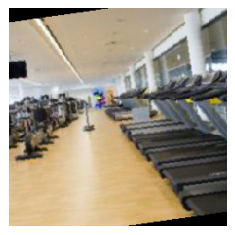

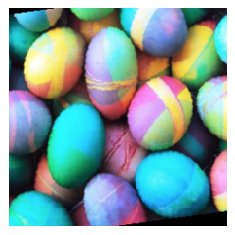

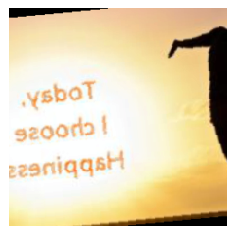

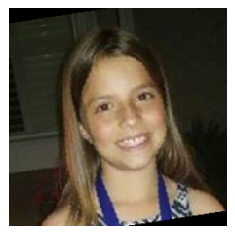

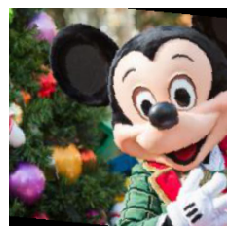

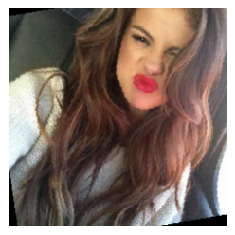

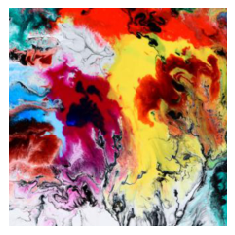

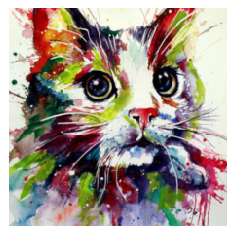

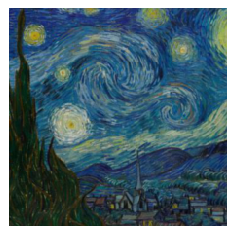

In [5]:
# IEJG - I will test the dataloaders before starting the training.
### Define a function to view the images
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

def test_image_loaders():
    images, label = next(iter(train_loader))
    imshow(images[0,:])
    imshow(images[1,:])
    imshow(images[2,:])
    imshow(images[3,:])
    imshow(images[4,:])
    imshow(images[5,:])
    
    images, label = next(iter(test_loader))
    imshow(images[0,:])
    imshow(images[1,:])
    imshow(images[2,:])
    
test_image_loaders()

In [6]:
def load_base_model(device, classes):
    model = models.resnet152(pretrained=True)
    # Use GPU if it's available
    

    ## Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
    
    for param in model.layer3.parameters():
        param.requires_grad = False
        
    for param in model.layer4.parameters():
        param.requires_grad = True
    new_fc = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(2048, 1024)),
                              ('relu', nn.ReLU()),
                              ('fc2', nn.Linear(1024, len(classes))),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))
    model.fc = new_fc

    model.to(device)
    return model

In [7]:
len(train_loader)

115

In [8]:
def train(inputs, labels, device, model, optimizer, criterion, running_loss):
    model.train()
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    logps = model.forward(inputs)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    return running_loss

In [9]:
def validate(loader, device, model, criterion):
    model.eval()
    test_loss = 0.0
    accuracy = 0.0
    valid_loss = 0.0
    step = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)
            test_loss += batch_loss.item()
            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            valid_loss += batch_loss.item()*inputs.size(0)
            step+=1
            print("current step {:} of {:}".format(step, len(loader)))
    valid_loss = valid_loss/len(loader.dataset)
    return test_loss, accuracy, valid_loss
    

In [12]:
def accuracy_calc(loader, model,epochs, epoch, running_loss, test_loss, accuracy, valid_loss, valid_loss_min, max_accu):
    steps = len(loader)
    print("Epoch {:}/{:}.. ".format(epoch+1, epochs),
          "Step: {:}.. ".format(steps),
          "Train loss: {:.3f}.. ".format(running_loss/steps),
          "Test loss: {:.3f}.. ".format(test_loss/len(loader)),
          "Test accuracy: {:.3f}.. ".format(accuracy/len(loader)),
          "Valid Loss: {:.3f}".format(valid_loss))

    #saving max accuracy
    calc_accu = accuracy/len(loader)
    print('lets see {:} / {:}'.format(calc_accu, max_accu))
    if max_accu < calc_accu:
        print("++++++ Accuracy increase {:.3f} to {:}   ===== Saving model =====".format(max_accu, calc_accu))
        torch.save(model.state_dict(), 'model_resnet_maxaccu_152_p99.pt')
        max_accu = calc_accu

    # saving max valid_loss
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'image2hashtag_resnet152_p99.pt')
        valid_loss_min = valid_loss
    return valid_loss_min, max_accu

In [11]:
def trainer_loop(train_loader, test_loader, model, epochs, lr, device, max_accu = 0.0):
    optimizer = optim.Adam([
                         {'params': model.layer3.parameters()},
                         {'params': model.layer4.parameters()},
                       {'params': model.fc.parameters()}], lr)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
    criterion = nn.NLLLoss()
    print_every = 5
    valid_loss_min = np.Inf # set initial "min" to infinity
    
    for epoch in range(epochs):
        steps = 0
        running_loss = 0
        for inputs, labels in train_loader:
            steps += 1
            running_loss = train(inputs, labels, device, model, optimizer, criterion, running_loss)
            print("Epoch {:}/{:}.. ".format(epoch+1, epochs),
              "Step: {:}/{:}.. ".format(steps,len(train_loader) ),
              "Train loss: {:.3f}.. ".format(running_loss/steps))
        test_loss, accuracy, valid_loss = validate(test_loader, device, model, criterion)
        valid_loss_min, max_accu = accuracy_calc(test_loader, model, epochs, epoch, running_loss, test_loss, accuracy, valid_loss, valid_loss_min, max_accu)
        print(test_loss, accuracy, valid_loss, max_accu)
        scheduler.step(valid_loss)
    return model

In [26]:
#final_model = load_checkpoint(device_to, class_names)
# for param in final_model.layer3.parameters():
#         param.requires_grad = True
        
# for param in final_model.layer4.parameters():
#     param.requires_grad = True

In [13]:
final_model = trainer_loop(train_loader, test_loader,load_base_model(device_to, class_names),epochs=15,lr =0.001,device=device_to )
#final_model = trainer_loop(train_loader, test_loader,final_model,epochs=30,lr =0.0001,device=device_to, max_accu = 0.86 )
#final_model = trainer_loop(train_loader, test_loader, load_checkpoint(device_to, class_names),epochs=30,lr =0.001,device=device_to, max_accu = 0.84 )

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
100.0%


('Epoch 1/15.. ', 'Step: 1/115.. ', 'Train loss: 3.361.. ')
('Epoch 1/15.. ', 'Step: 2/115.. ', 'Train loss: 3.450.. ')
('Epoch 1/15.. ', 'Step: 3/115.. ', 'Train loss: 3.788.. ')
('Epoch 1/15.. ', 'Step: 4/115.. ', 'Train loss: 3.650.. ')
('Epoch 1/15.. ', 'Step: 5/115.. ', 'Train loss: 3.615.. ')
('Epoch 1/15.. ', 'Step: 6/115.. ', 'Train loss: 3.517.. ')
('Epoch 1/15.. ', 'Step: 7/115.. ', 'Train loss: 3.453.. ')
('Epoch 1/15.. ', 'Step: 8/115.. ', 'Train loss: 3.427.. ')
('Epoch 1/15.. ', 'Step: 9/115.. ', 'Train loss: 3.369.. ')
('Epoch 1/15.. ', 'Step: 10/115.. ', 'Train loss: 3.324.. ')
('Epoch 1/15.. ', 'Step: 11/115.. ', 'Train loss: 3.253.. ')
('Epoch 1/15.. ', 'Step: 12/115.. ', 'Train loss: 3.201.. ')
('Epoch 1/15.. ', 'Step: 13/115.. ', 'Train loss: 3.135.. ')
('Epoch 1/15.. ', 'Step: 14/115.. ', 'Train loss: 3.113.. ')
('Epoch 1/15.. ', 'Step: 15/115.. ', 'Train loss: 3.044.. ')
('Epoch 1/15.. ', 'Step: 16/115.. ', 'Train loss: 3.020.. ')
('Epoch 1/15.. ', 'Step: 17/115..

('Epoch 2/15.. ', 'Step: 10/115.. ', 'Train loss: 1.209.. ')
('Epoch 2/15.. ', 'Step: 11/115.. ', 'Train loss: 1.184.. ')
('Epoch 2/15.. ', 'Step: 12/115.. ', 'Train loss: 1.155.. ')
('Epoch 2/15.. ', 'Step: 13/115.. ', 'Train loss: 1.140.. ')
('Epoch 2/15.. ', 'Step: 14/115.. ', 'Train loss: 1.160.. ')
('Epoch 2/15.. ', 'Step: 15/115.. ', 'Train loss: 1.140.. ')
('Epoch 2/15.. ', 'Step: 16/115.. ', 'Train loss: 1.108.. ')
('Epoch 2/15.. ', 'Step: 17/115.. ', 'Train loss: 1.122.. ')
('Epoch 2/15.. ', 'Step: 18/115.. ', 'Train loss: 1.102.. ')
('Epoch 2/15.. ', 'Step: 19/115.. ', 'Train loss: 1.100.. ')
('Epoch 2/15.. ', 'Step: 20/115.. ', 'Train loss: 1.113.. ')
('Epoch 2/15.. ', 'Step: 21/115.. ', 'Train loss: 1.094.. ')
('Epoch 2/15.. ', 'Step: 22/115.. ', 'Train loss: 1.118.. ')
('Epoch 2/15.. ', 'Step: 23/115.. ', 'Train loss: 1.117.. ')
('Epoch 2/15.. ', 'Step: 24/115.. ', 'Train loss: 1.137.. ')
('Epoch 2/15.. ', 'Step: 25/115.. ', 'Train loss: 1.126.. ')
('Epoch 2/15.. ', 'Step:

('Epoch 3/15.. ', 'Step: 19/115.. ', 'Train loss: 0.755.. ')
('Epoch 3/15.. ', 'Step: 20/115.. ', 'Train loss: 0.768.. ')
('Epoch 3/15.. ', 'Step: 21/115.. ', 'Train loss: 0.747.. ')
('Epoch 3/15.. ', 'Step: 22/115.. ', 'Train loss: 0.746.. ')
('Epoch 3/15.. ', 'Step: 23/115.. ', 'Train loss: 0.726.. ')
('Epoch 3/15.. ', 'Step: 24/115.. ', 'Train loss: 0.729.. ')
('Epoch 3/15.. ', 'Step: 25/115.. ', 'Train loss: 0.737.. ')
('Epoch 3/15.. ', 'Step: 26/115.. ', 'Train loss: 0.735.. ')
('Epoch 3/15.. ', 'Step: 27/115.. ', 'Train loss: 0.735.. ')
('Epoch 3/15.. ', 'Step: 28/115.. ', 'Train loss: 0.742.. ')
('Epoch 3/15.. ', 'Step: 29/115.. ', 'Train loss: 0.745.. ')
('Epoch 3/15.. ', 'Step: 30/115.. ', 'Train loss: 0.741.. ')
('Epoch 3/15.. ', 'Step: 31/115.. ', 'Train loss: 0.740.. ')
('Epoch 3/15.. ', 'Step: 32/115.. ', 'Train loss: 0.735.. ')
('Epoch 3/15.. ', 'Step: 33/115.. ', 'Train loss: 0.735.. ')
('Epoch 3/15.. ', 'Step: 34/115.. ', 'Train loss: 0.742.. ')
('Epoch 3/15.. ', 'Step:

('Epoch 4/15.. ', 'Step: 28/115.. ', 'Train loss: 0.548.. ')
('Epoch 4/15.. ', 'Step: 29/115.. ', 'Train loss: 0.545.. ')
('Epoch 4/15.. ', 'Step: 30/115.. ', 'Train loss: 0.547.. ')
('Epoch 4/15.. ', 'Step: 31/115.. ', 'Train loss: 0.553.. ')
('Epoch 4/15.. ', 'Step: 32/115.. ', 'Train loss: 0.550.. ')
('Epoch 4/15.. ', 'Step: 33/115.. ', 'Train loss: 0.545.. ')
('Epoch 4/15.. ', 'Step: 34/115.. ', 'Train loss: 0.540.. ')
('Epoch 4/15.. ', 'Step: 35/115.. ', 'Train loss: 0.547.. ')
('Epoch 4/15.. ', 'Step: 36/115.. ', 'Train loss: 0.547.. ')
('Epoch 4/15.. ', 'Step: 37/115.. ', 'Train loss: 0.543.. ')
('Epoch 4/15.. ', 'Step: 38/115.. ', 'Train loss: 0.541.. ')
('Epoch 4/15.. ', 'Step: 39/115.. ', 'Train loss: 0.558.. ')
('Epoch 4/15.. ', 'Step: 40/115.. ', 'Train loss: 0.560.. ')
('Epoch 4/15.. ', 'Step: 41/115.. ', 'Train loss: 0.556.. ')
('Epoch 4/15.. ', 'Step: 42/115.. ', 'Train loss: 0.550.. ')
('Epoch 4/15.. ', 'Step: 43/115.. ', 'Train loss: 0.555.. ')
('Epoch 4/15.. ', 'Step:

('Epoch 5/15.. ', 'Step: 38/115.. ', 'Train loss: 0.443.. ')
('Epoch 5/15.. ', 'Step: 39/115.. ', 'Train loss: 0.447.. ')
('Epoch 5/15.. ', 'Step: 40/115.. ', 'Train loss: 0.454.. ')
('Epoch 5/15.. ', 'Step: 41/115.. ', 'Train loss: 0.464.. ')
('Epoch 5/15.. ', 'Step: 42/115.. ', 'Train loss: 0.460.. ')
('Epoch 5/15.. ', 'Step: 43/115.. ', 'Train loss: 0.460.. ')
('Epoch 5/15.. ', 'Step: 44/115.. ', 'Train loss: 0.463.. ')
('Epoch 5/15.. ', 'Step: 45/115.. ', 'Train loss: 0.465.. ')
('Epoch 5/15.. ', 'Step: 46/115.. ', 'Train loss: 0.476.. ')
('Epoch 5/15.. ', 'Step: 47/115.. ', 'Train loss: 0.469.. ')
('Epoch 5/15.. ', 'Step: 48/115.. ', 'Train loss: 0.464.. ')
('Epoch 5/15.. ', 'Step: 49/115.. ', 'Train loss: 0.468.. ')
('Epoch 5/15.. ', 'Step: 50/115.. ', 'Train loss: 0.470.. ')
('Epoch 5/15.. ', 'Step: 51/115.. ', 'Train loss: 0.469.. ')
('Epoch 5/15.. ', 'Step: 52/115.. ', 'Train loss: 0.474.. ')
('Epoch 5/15.. ', 'Step: 53/115.. ', 'Train loss: 0.470.. ')
('Epoch 5/15.. ', 'Step:

('Epoch 6/15.. ', 'Step: 47/115.. ', 'Train loss: 0.367.. ')
('Epoch 6/15.. ', 'Step: 48/115.. ', 'Train loss: 0.366.. ')
('Epoch 6/15.. ', 'Step: 49/115.. ', 'Train loss: 0.366.. ')
('Epoch 6/15.. ', 'Step: 50/115.. ', 'Train loss: 0.371.. ')
('Epoch 6/15.. ', 'Step: 51/115.. ', 'Train loss: 0.367.. ')
('Epoch 6/15.. ', 'Step: 52/115.. ', 'Train loss: 0.371.. ')
('Epoch 6/15.. ', 'Step: 53/115.. ', 'Train loss: 0.371.. ')
('Epoch 6/15.. ', 'Step: 54/115.. ', 'Train loss: 0.374.. ')
('Epoch 6/15.. ', 'Step: 55/115.. ', 'Train loss: 0.382.. ')
('Epoch 6/15.. ', 'Step: 56/115.. ', 'Train loss: 0.377.. ')
('Epoch 6/15.. ', 'Step: 57/115.. ', 'Train loss: 0.382.. ')
('Epoch 6/15.. ', 'Step: 58/115.. ', 'Train loss: 0.382.. ')
('Epoch 6/15.. ', 'Step: 59/115.. ', 'Train loss: 0.380.. ')
('Epoch 6/15.. ', 'Step: 60/115.. ', 'Train loss: 0.376.. ')
('Epoch 6/15.. ', 'Step: 61/115.. ', 'Train loss: 0.377.. ')
('Epoch 6/15.. ', 'Step: 62/115.. ', 'Train loss: 0.378.. ')
('Epoch 6/15.. ', 'Step:

('Epoch 7/15.. ', 'Step: 58/115.. ', 'Train loss: 0.276.. ')
('Epoch 7/15.. ', 'Step: 59/115.. ', 'Train loss: 0.279.. ')
('Epoch 7/15.. ', 'Step: 60/115.. ', 'Train loss: 0.283.. ')
('Epoch 7/15.. ', 'Step: 61/115.. ', 'Train loss: 0.283.. ')
('Epoch 7/15.. ', 'Step: 62/115.. ', 'Train loss: 0.281.. ')
('Epoch 7/15.. ', 'Step: 63/115.. ', 'Train loss: 0.286.. ')
('Epoch 7/15.. ', 'Step: 64/115.. ', 'Train loss: 0.288.. ')
('Epoch 7/15.. ', 'Step: 65/115.. ', 'Train loss: 0.289.. ')
('Epoch 7/15.. ', 'Step: 66/115.. ', 'Train loss: 0.289.. ')
('Epoch 7/15.. ', 'Step: 67/115.. ', 'Train loss: 0.291.. ')
('Epoch 7/15.. ', 'Step: 68/115.. ', 'Train loss: 0.290.. ')
('Epoch 7/15.. ', 'Step: 69/115.. ', 'Train loss: 0.289.. ')
('Epoch 7/15.. ', 'Step: 70/115.. ', 'Train loss: 0.291.. ')
('Epoch 7/15.. ', 'Step: 71/115.. ', 'Train loss: 0.289.. ')
('Epoch 7/15.. ', 'Step: 72/115.. ', 'Train loss: 0.288.. ')
('Epoch 7/15.. ', 'Step: 73/115.. ', 'Train loss: 0.285.. ')
('Epoch 7/15.. ', 'Step:

('Epoch 8/15.. ', 'Step: 68/115.. ', 'Train loss: 0.263.. ')
('Epoch 8/15.. ', 'Step: 69/115.. ', 'Train loss: 0.263.. ')
('Epoch 8/15.. ', 'Step: 70/115.. ', 'Train loss: 0.261.. ')
('Epoch 8/15.. ', 'Step: 71/115.. ', 'Train loss: 0.260.. ')
('Epoch 8/15.. ', 'Step: 72/115.. ', 'Train loss: 0.260.. ')
('Epoch 8/15.. ', 'Step: 73/115.. ', 'Train loss: 0.258.. ')
('Epoch 8/15.. ', 'Step: 74/115.. ', 'Train loss: 0.256.. ')
('Epoch 8/15.. ', 'Step: 75/115.. ', 'Train loss: 0.254.. ')
('Epoch 8/15.. ', 'Step: 76/115.. ', 'Train loss: 0.255.. ')
('Epoch 8/15.. ', 'Step: 77/115.. ', 'Train loss: 0.254.. ')
('Epoch 8/15.. ', 'Step: 78/115.. ', 'Train loss: 0.259.. ')
('Epoch 8/15.. ', 'Step: 79/115.. ', 'Train loss: 0.258.. ')
('Epoch 8/15.. ', 'Step: 80/115.. ', 'Train loss: 0.258.. ')
('Epoch 8/15.. ', 'Step: 81/115.. ', 'Train loss: 0.256.. ')
('Epoch 8/15.. ', 'Step: 82/115.. ', 'Train loss: 0.257.. ')
('Epoch 8/15.. ', 'Step: 83/115.. ', 'Train loss: 0.259.. ')
('Epoch 8/15.. ', 'Step:

('Epoch 9/15.. ', 'Step: 79/115.. ', 'Train loss: 0.213.. ')
('Epoch 9/15.. ', 'Step: 80/115.. ', 'Train loss: 0.213.. ')
('Epoch 9/15.. ', 'Step: 81/115.. ', 'Train loss: 0.214.. ')
('Epoch 9/15.. ', 'Step: 82/115.. ', 'Train loss: 0.216.. ')
('Epoch 9/15.. ', 'Step: 83/115.. ', 'Train loss: 0.214.. ')
('Epoch 9/15.. ', 'Step: 84/115.. ', 'Train loss: 0.214.. ')
('Epoch 9/15.. ', 'Step: 85/115.. ', 'Train loss: 0.214.. ')
('Epoch 9/15.. ', 'Step: 86/115.. ', 'Train loss: 0.212.. ')
('Epoch 9/15.. ', 'Step: 87/115.. ', 'Train loss: 0.214.. ')
('Epoch 9/15.. ', 'Step: 88/115.. ', 'Train loss: 0.214.. ')
('Epoch 9/15.. ', 'Step: 89/115.. ', 'Train loss: 0.213.. ')
('Epoch 9/15.. ', 'Step: 90/115.. ', 'Train loss: 0.213.. ')
('Epoch 9/15.. ', 'Step: 91/115.. ', 'Train loss: 0.210.. ')
('Epoch 9/15.. ', 'Step: 92/115.. ', 'Train loss: 0.212.. ')
('Epoch 9/15.. ', 'Step: 93/115.. ', 'Train loss: 0.213.. ')
('Epoch 9/15.. ', 'Step: 94/115.. ', 'Train loss: 0.215.. ')
('Epoch 9/15.. ', 'Step:

('Epoch 10/15.. ', 'Step: 87/115.. ', 'Train loss: 0.191.. ')
('Epoch 10/15.. ', 'Step: 88/115.. ', 'Train loss: 0.189.. ')
('Epoch 10/15.. ', 'Step: 89/115.. ', 'Train loss: 0.189.. ')
('Epoch 10/15.. ', 'Step: 90/115.. ', 'Train loss: 0.189.. ')
('Epoch 10/15.. ', 'Step: 91/115.. ', 'Train loss: 0.194.. ')
('Epoch 10/15.. ', 'Step: 92/115.. ', 'Train loss: 0.194.. ')
('Epoch 10/15.. ', 'Step: 93/115.. ', 'Train loss: 0.192.. ')
('Epoch 10/15.. ', 'Step: 94/115.. ', 'Train loss: 0.191.. ')
('Epoch 10/15.. ', 'Step: 95/115.. ', 'Train loss: 0.190.. ')
('Epoch 10/15.. ', 'Step: 96/115.. ', 'Train loss: 0.189.. ')
('Epoch 10/15.. ', 'Step: 97/115.. ', 'Train loss: 0.190.. ')
('Epoch 10/15.. ', 'Step: 98/115.. ', 'Train loss: 0.189.. ')
('Epoch 10/15.. ', 'Step: 99/115.. ', 'Train loss: 0.189.. ')
('Epoch 10/15.. ', 'Step: 100/115.. ', 'Train loss: 0.189.. ')
('Epoch 10/15.. ', 'Step: 101/115.. ', 'Train loss: 0.187.. ')
('Epoch 10/15.. ', 'Step: 102/115.. ', 'Train loss: 0.189.. ')
('Epo

('Epoch 11/15.. ', 'Step: 96/115.. ', 'Train loss: 0.178.. ')
('Epoch 11/15.. ', 'Step: 97/115.. ', 'Train loss: 0.177.. ')
('Epoch 11/15.. ', 'Step: 98/115.. ', 'Train loss: 0.175.. ')
('Epoch 11/15.. ', 'Step: 99/115.. ', 'Train loss: 0.177.. ')
('Epoch 11/15.. ', 'Step: 100/115.. ', 'Train loss: 0.177.. ')
('Epoch 11/15.. ', 'Step: 101/115.. ', 'Train loss: 0.177.. ')
('Epoch 11/15.. ', 'Step: 102/115.. ', 'Train loss: 0.179.. ')
('Epoch 11/15.. ', 'Step: 103/115.. ', 'Train loss: 0.177.. ')
('Epoch 11/15.. ', 'Step: 104/115.. ', 'Train loss: 0.177.. ')
('Epoch 11/15.. ', 'Step: 105/115.. ', 'Train loss: 0.176.. ')
('Epoch 11/15.. ', 'Step: 106/115.. ', 'Train loss: 0.176.. ')
('Epoch 11/15.. ', 'Step: 107/115.. ', 'Train loss: 0.174.. ')
('Epoch 11/15.. ', 'Step: 108/115.. ', 'Train loss: 0.174.. ')
('Epoch 11/15.. ', 'Step: 109/115.. ', 'Train loss: 0.173.. ')
('Epoch 11/15.. ', 'Step: 110/115.. ', 'Train loss: 0.174.. ')
('Epoch 11/15.. ', 'Step: 111/115.. ', 'Train loss: 0.173..

('Epoch 12/15.. ', 'Step: 105/115.. ', 'Train loss: 0.144.. ')
('Epoch 12/15.. ', 'Step: 106/115.. ', 'Train loss: 0.145.. ')
('Epoch 12/15.. ', 'Step: 107/115.. ', 'Train loss: 0.147.. ')
('Epoch 12/15.. ', 'Step: 108/115.. ', 'Train loss: 0.146.. ')
('Epoch 12/15.. ', 'Step: 109/115.. ', 'Train loss: 0.148.. ')
('Epoch 12/15.. ', 'Step: 110/115.. ', 'Train loss: 0.148.. ')
('Epoch 12/15.. ', 'Step: 111/115.. ', 'Train loss: 0.149.. ')
('Epoch 12/15.. ', 'Step: 112/115.. ', 'Train loss: 0.150.. ')
('Epoch 12/15.. ', 'Step: 113/115.. ', 'Train loss: 0.149.. ')
('Epoch 12/15.. ', 'Step: 114/115.. ', 'Train loss: 0.150.. ')
('Epoch 12/15.. ', 'Step: 115/115.. ', 'Train loss: 0.149.. ')
current step 1 of 13
current step 2 of 13
current step 3 of 13
current step 4 of 13
current step 5 of 13
current step 6 of 13
current step 7 of 13
current step 8 of 13
current step 9 of 13
current step 10 of 13
current step 11 of 13
current step 12 of 13
current step 13 of 13
('Epoch 12/15.. ', 'Step: 13..

('Epoch 13/15.. ', 'Step: 114/115.. ', 'Train loss: 0.114.. ')
('Epoch 13/15.. ', 'Step: 115/115.. ', 'Train loss: 0.115.. ')
current step 1 of 13
current step 2 of 13
current step 3 of 13
current step 4 of 13
current step 5 of 13
current step 6 of 13
current step 7 of 13
current step 8 of 13
current step 9 of 13
current step 10 of 13
current step 11 of 13
current step 12 of 13
current step 13 of 13
('Epoch 13/15.. ', 'Step: 13.. ', 'Train loss: 1.017.. ', 'Test loss: 0.778.. ', 'Test accuracy: 0.830.. ', 'Valid Loss: 0.786')
lets see 0.829807703312 / 0.873076943251
(10.108495622873306, 10.787500143051147, 0.7860913979820907, 0.8730769432508029)
('Epoch 14/15.. ', 'Step: 1/115.. ', 'Train loss: 0.037.. ')
('Epoch 14/15.. ', 'Step: 2/115.. ', 'Train loss: 0.070.. ')
('Epoch 14/15.. ', 'Step: 3/115.. ', 'Train loss: 0.087.. ')
('Epoch 14/15.. ', 'Step: 4/115.. ', 'Train loss: 0.066.. ')
('Epoch 14/15.. ', 'Step: 5/115.. ', 'Train loss: 0.060.. ')
('Epoch 14/15.. ', 'Step: 6/115.. ', 'Tra

('Epoch 15/15.. ', 'Step: 1/115.. ', 'Train loss: 0.056.. ')
('Epoch 15/15.. ', 'Step: 2/115.. ', 'Train loss: 0.042.. ')
('Epoch 15/15.. ', 'Step: 3/115.. ', 'Train loss: 0.044.. ')
('Epoch 15/15.. ', 'Step: 4/115.. ', 'Train loss: 0.071.. ')
('Epoch 15/15.. ', 'Step: 5/115.. ', 'Train loss: 0.060.. ')
('Epoch 15/15.. ', 'Step: 6/115.. ', 'Train loss: 0.063.. ')
('Epoch 15/15.. ', 'Step: 7/115.. ', 'Train loss: 0.054.. ')
('Epoch 15/15.. ', 'Step: 8/115.. ', 'Train loss: 0.068.. ')
('Epoch 15/15.. ', 'Step: 9/115.. ', 'Train loss: 0.068.. ')
('Epoch 15/15.. ', 'Step: 10/115.. ', 'Train loss: 0.071.. ')
('Epoch 15/15.. ', 'Step: 11/115.. ', 'Train loss: 0.068.. ')
('Epoch 15/15.. ', 'Step: 12/115.. ', 'Train loss: 0.068.. ')
('Epoch 15/15.. ', 'Step: 13/115.. ', 'Train loss: 0.065.. ')
('Epoch 15/15.. ', 'Step: 14/115.. ', 'Train loss: 0.063.. ')
('Epoch 15/15.. ', 'Step: 15/115.. ', 'Train loss: 0.065.. ')
('Epoch 15/15.. ', 'Step: 16/115.. ', 'Train loss: 0.068.. ')
('Epoch 15/15.. '

1020


'_DataLoader__initialized, __class__, __delattr__, __dict__, __dir__, __doc__, __eq__, __format__, __ge__, __getattribute__, __gt__, __hash__, __init__, __init_subclass__, __iter__, __le__, __len__, __lt__, __module__, __ne__, __new__, __reduce__, __reduce_ex__, __repr__, __setattr__, __sizeof__, __str__, __subclasshook__, __weakref__, batch_sampler, batch_size, collate_fn, dataset, drop_last, num_workers, pin_memory, sampler, timeout, worker_init_fn'

In [12]:
def load_checkpoint(device, classes, expand_classes = False ):
    model = load_base_model(device_to, classes)
    temp_model = torch.load('model_resnet_maxaccu_152_p99.pt', map_location=lambda storage, loc: storage)
    fc = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 1024)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(1024, len(temp_model['fc.fc2.weight']))),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    model.fc = fc
    model.load_state_dict(temp_model)
    if expand_classes:
        # if there are new classes replace last fully connected layer
        new_fc = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(2048, 1024)),
                              ('relu', nn.ReLU()),
                              ('fc2', nn.Linear(1024, len(classes))),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))
        model.fc = new_fc
    model.to(device)
    return model

In [13]:
device_to


device(type='cuda')

In [14]:
def model_class_validation(loader, model, device, criterion, classes):
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    batch_size = 50
    model.eval() # prep model for evaluation
    with torch.no_grad():
        for data, target in loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            data, target = data.to(device), target.to(device)
            print(device, data.size(), target.size())
            output = model.forward(data)
            # calculate the loss
            loss = criterion(output, target)
            # update test loss 
            test_loss += loss.item()*data.size(0)
            # convert output probabilities to predicted class
            _, pred = torch.max(output, 1)
            # compare predictions to true label
            correct = np.squeeze(pred.eq(target.data.view_as(pred)))
            # calculate test accuracy for each object class
            for i in range(target.size(0)):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

        # calculate and print avg test loss
        test_loss = test_loss/len(loader.dataset)
        print('Test Loss: {:.6f}\n'.format(test_loss))

        for i in range(len(class_total)):
            if class_total[i] > 0:
                 print('Test Accuracy of %5s %5s: %2d%% (%2d/%2d)' % (
                  classes[i],str(i+1) ,100.0 * class_correct[i] / class_total[i],
                  np.sum(class_correct[i]), np.sum(class_total[i])))
            else:
                print('Test Accuracy of %5s: N/A (no training examples)' % (i))

        print('\nTest Accuracy (Overall): %.6f%% (%2d/%2d)' % (
          100. * np.sum(class_correct) / np.sum(class_total),
          np.sum(class_correct), np.sum(class_total)))

In [41]:
model_class_validation(test_loader, load_checkpoint(device_to, class_names), device_to, nn.NLLLoss(), class_names )

(device(type='cuda'), torch.Size([20, 3, 224, 224]), torch.Size([20]))
(device(type='cuda'), torch.Size([20, 3, 224, 224]), torch.Size([20]))
(device(type='cuda'), torch.Size([20, 3, 224, 224]), torch.Size([20]))
(device(type='cuda'), torch.Size([20, 3, 224, 224]), torch.Size([20]))
(device(type='cuda'), torch.Size([20, 3, 224, 224]), torch.Size([20]))
(device(type='cuda'), torch.Size([20, 3, 224, 224]), torch.Size([20]))
(device(type='cuda'), torch.Size([20, 3, 224, 224]), torch.Size([20]))
(device(type='cuda'), torch.Size([20, 3, 224, 224]), torch.Size([20]))
(device(type='cuda'), torch.Size([20, 3, 224, 224]), torch.Size([20]))
(device(type='cuda'), torch.Size([20, 3, 224, 224]), torch.Size([20]))
(device(type='cuda'), torch.Size([20, 3, 224, 224]), torch.Size([20]))
(device(type='cuda'), torch.Size([20, 3, 224, 224]), torch.Size([20]))
(device(type='cuda'), torch.Size([16, 3, 224, 224]), torch.Size([16]))
Test Loss: 0.716137

Test Accuracy of   art     1: 100% (10/10)
Test Accuracy